파이썬 머신러닝 완벽 가이드 개정2판 ch8.10-11 p.566-583

### **[개념 정리]**

### **10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**

일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제. 데이터는 제품의 속성 및 제품 설명 등의 텍스트 데이터로, 데이터 기반 제품의 가격을 예측

- 데이터 세트 속성: 데이터 id, 제품명, 제품 상태, 카테고리 명, 브랜드 이름, 제품가격(타깃), 배송비 무료여부, 제품에 대한 설명
- 회귀로 price 예측
- 텍스트 형태(비정형)속성 + 정형 속성을 같이 적용해보기

(1) 데이터 전처리

- null 값 처리: 이후 적절한 문자열로 치환
  - brand_name은 중요 칼럼이지만, null이 많음
- 📄 price 칼럼: 적은 가격값에 왜곡된 분포. 로그 값으로 변환해 정규분포 가깝게 하기
- 📄 shipping 칼럼: 값이 균일함
- 📄 item_condition_id: 1,2,3으로 구성
- 📄 item_description: 별도 설명이 없는 경우 null값 대신 no description yet으로 채워져 있음 -> 적젛한 값으로 변경 필요
- 📄 category_name: 텍스트 데이터. /로 분리된 카테고리를 하나의 문자열로 나타냄. (대분류/중분류/소분류). /기준 단어 토큰화해 각각 별도의 피처로 저장함
  - split_cat()함수를 만들어 적용
  - null값인 경우에는 '대/중/소분류'모두 'Other_Null'값 부여.
  - apply lambda가 list 요소들로 반환되므로 zip(*~).apply로 여러개의 칼럼으로 분리.
- 📄 brand_name, category_name, item_description의 null: 일괄적으로 other null로 변경


(2) 피처 인코딩과 피처 벡터화

- 문자열 칼럼 중 레이블/원핫 인코딩 수행하거나 피처 벡터화로 변환될 칼럼 선별
- 회귀 예측 모델(선형/회귀트리)이므로 원핫인코딩 적용
- 짧은 텍스트는 Count기반 벡터화, 긴 텍스트는 TD-IDF 기반 벡터화
- 📄 brand_name: 상품의 브랜드명. 명료한 문자열이므로 원-핫 인코딩 변환
- 📄 name: 개별 고유 상품명. 적은 단어 위주의 텍스트이므로 Count기반 피처 벡터화 변환
- 📄 category_name: 대, 중, 소 분류 칼럼으로 분리됨. 각각 원-핫 인코딩 적용
- 📄 shipping: 0,1 -> 원핫인코딩
- 📄 item_condition_id: 1,2,3,4,5 -> 원핫인코딩
- 📄 item_description: 긴 텍스트. 평균 문자열 크기(str.len().mean())이 145자임. TF-IDF 변환

- 피처 벡터화 시 희소행렬을 반환하므로 희소 행렬 객체 변수끼리 결합해 새로운 데이터 세트로 구성
- 인코딩 대상도 밀집이 아닌 희소 행렬 형태로 인코딩 적용
  - 원핫인코딩 시 OneHotEncoder 대신 LabelBinarizer이용(spares_out = True): 희소 행렬 형태의 원핫 인코딩 변환 지원
  - 개별 칼럼의 희소 행렬을 hstack()으로 칼럼 레벨 결합
    - 인코딩 칼럼이 매우 많아지지만, 피처 벡터화 후 문자열 백터화의 매우 많은 칼럼과 결합되므로 문제 없음
  - 결합 데이터는 많은 메모리를 사용하므로 모델 적용 시마다 결합해 이용

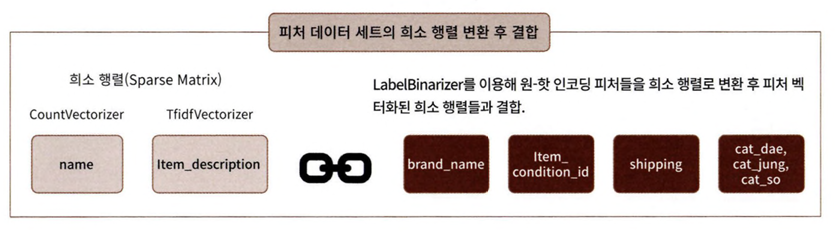

(3) 릿지 회귀 모델 구축 및 평가

- 모델평가 로직 함수 생성(rmsle(y.y_pred)): RMSLE 평가지표로 함(오류 값에 로그를 취하는 방식) 낮은 가격보다 높은 가격에서 오류 발생시 오류값이 더 커지는 것을 억제
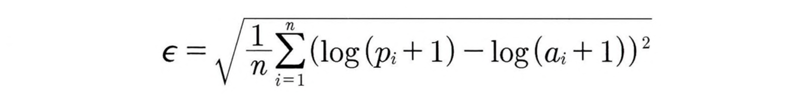

- price에 로그변환을 했으므로 예측된 price 값을 다시 로그의 역변환(지수변환) 수행해 원복해야함
  - -> 원복 후 rmsle 계산: evaluate_org_price 함수 생성

- 학습 데이터 생성, 모델 학습/예측
  - Ridge로 회귀예측 수행
  - Item_description 속성의 영향 파악: 피처 벡터화 데이터 포함/포함X 데이터 비교해보면 포함했을 때 rmsle가 많이 감소 -> 중요한 영향

(4) LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

- LGBM 회귀: Ridge보다는 성능이 나아짐
- LGBM의 예측 결괏값과 Ridge 결괏값을 서로 앙상블해 최종 예측 결괏값 도출 (배합 비율은 여러번 시도) --> 예측 성능 개선됨

### **[코드 필사]**

- **데이터 전처리**

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(539597, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539597 entries, 0 to 539596
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           539597 non-null  int64  
 1   name               539597 non-null  object 
 2   item_condition_id  539597 non-null  int64  
 3   category_name      537286 non-null  object 
 4   brand_name         309462 non-null  object 
 5   price              539597 non-null  float64
 6   shipping           539597 non-null  int64  
 7   item_description   539596 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 32.9+ MB
None


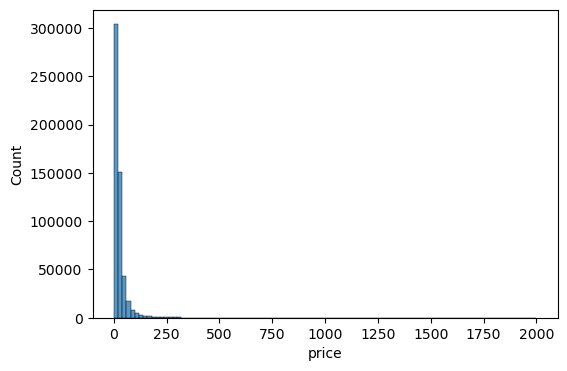

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

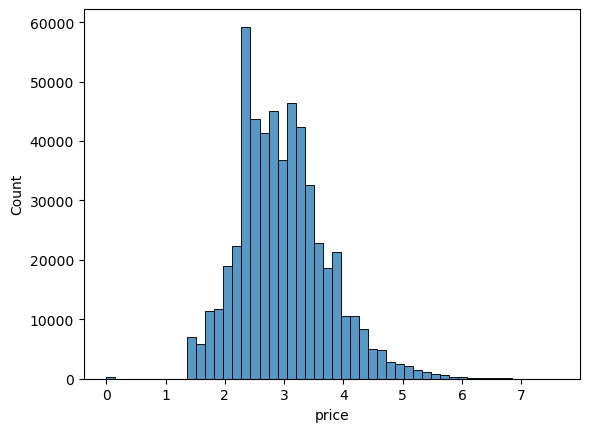

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [5]:
# price에 로그변환
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [6]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\n item_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    298710
1    240887
Name: shipping, dtype: int64

 item_condition_id 값 유형: 
 1    232795
3    157233
2    137108
4     11594
5       867
Name: item_condition_id, dtype: int64


In [7]:
boolean_cond = mercari_df['item_description']== 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

30028

In [8]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 Women                     241837
Beauty                     75854
Kids                       62216
Electronics                44651
Men                        34121
Home                       24837
Vintage & Collectibles     16975
Other                      16580
Handmade                   11125
Sports & Outdoors           9090
Other_Null                  2311
Name: cat_dae, dtype: int64
중분류 개수: 114
소분류 개수: 827


In [9]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

- **피처 인코딩과 피처 벡터화**

In [10]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 3658
brand name sample 5건: 
 Other_Null           230135
PINK                  19643
Nike                  19388
Victoria's Secret     17634
LuLaRoe               11268
Name: brand_name, dtype: int64


In [11]:
print('name의 종류 개수: ', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name의 종류 개수:  473687
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [12]:
# item_description 칼럼의 평균 문자열 크기와 텍스트 2개 추출
pd.set_option('max_colwidth', 200)

print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.6480762494973


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [13]:
# name 속성 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (539597, 60826)
item_description vectorization shape: (539597, 50000)


In [14]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [15]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape: {0}, X_item_cond_id shape: {1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape: {0}, X_cat_dae shape: {1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape: {0}, X_cat_so shape: {1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (539597, 3658), X_item_cond_id shape: (539597, 5)
X_shipping shape: (539597, 1), X_cat_dae shape: (539597, 11)
X_cat_jung shape: (539597, 114), X_cat_so shape: (539597, 827)


In [16]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (539597, 115442)


0

- **릿지 회귀 모델 구축 및 평가**

In [17]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [18]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용헤 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

In [19]:
# Ridge 회귀 실습
linear_model = Ridge(solver='lsqr', fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))


sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5068929627247082
Item Description을 포함한 rmsle 값: 0.48148992468278634


- **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

In [22]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 145.196329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1051062
[LightGBM] [Info] Number of data points in the train set: 431677, number of used features: 57482
[LightGBM] [Info] Start training from score 2.979246


C:\Users\curio\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값: 0.48099800373758383


In [23]:
preds = lgbm_preds*0.45 + linear_preds *0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle값: 0.4628125832341656


### **11. 정리**

머신러닝 기반의 텍스트 분석 프로젝트:
    - 1. 텍스트 사전정제
    - 2. 단어들을 피처 벡터화(BOW-Count, TF-IDF)
    - 3. 피처 데이터 세트에 모델 학습, 예측, 평가

- 텍스트 정규화: 피처 벡터화 진행 전 수행하는 다양한 사전작업을 의미 - 텍스트 클렌징, 대소문자 변경, 단어 토큰화, 필터링, 어근 추출 등
- 문장이 긴 경우는 TF-IDF기반 벡터가 더 정확함
- 감정분석: 지도학습 기반 이진 분류 / 감성사전 Lexicon
- 토픽모델링: LDA 이용
- 텍스트 군집화: K-평균 군집과 이용
- 텍스트 유사도: 코사인 유사도 이용

비정형 데이터의 머신러닝 분석으로 많은 인사이트를 얻게됨